In [1]:
import torch.nn as nn
import torch
import torch_geometric
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader
import numpy as np
import scipy.sparse as sp

torch.random.manual_seed(0)

def get_a_norm(data: torch_geometric.data.Data):
    d = np.ones(len(data.edge_index[0]))
    r = data.edge_index[0]
    c = data.edge_index[1]

    A = sp.coo_matrix(
        (d, (r, c)),
        shape=(data.num_nodes, data.num_nodes),
        dtype=np.float32
    )
    A = A + sp.eye(data.num_nodes)
    d_sqrt_inv = np.array(1.0 / np.sqrt(A.sum(axis=1))).flatten()
    nam = d_sqrt_inv.dot(A).dot(d_sqrt_inv)
    return nam

def prepare_graphs_batch(data: torch_geometric.data.Data):
    adj_matrices = []
    feature_matrices = []
    batch_indices = []
    labels = []

    for i, d in enumerate(data):
        adj_matrices.append(get_a_norm(d))
        feature_matrices.append(d.x)
        batch_indices.append(torch.tensor([i] * d.num_nodes, dtype=torch.int64))
        labels.append(d.y.float())

    nam = sp.block_diag(adj_matrices)
    rows, cols = nam.nonzero()
    values = nam.data
    indices = torch.LongTensor([rows, cols])
    values_torch = torch.FloatTensor(values)
    
    nam_t = torch.sparse_coo_tensor(indices, values_torch, nam.shape)    
    feature_matrices = torch.cat(feature_matrices, dim=0)
    batch_indices = torch.cat(batch_indices, dim=0)
    labels = torch.cat(labels, dim=0)

    return nam_t, feature_matrices, batch_indices, labels


dataset = TUDataset(root='data/TU', name='PROTEINS', use_node_attr=True)
indices = torch.randperm(len(dataset))
idx_80 = int(len(indices)*0.8)
idx_90 = int(len(indices)*0.9)
train_dataset = dataset[indices][:idx_80]
valid_dataset = dataset[indices][idx_80:idx_90]
test_dataset = dataset[indices][idx_90:]

train_a_norm, train_features, train_batch_idx, train_labels = prepare_graphs_batch(train_dataset)
valid_a_norm, valid_features, valid_batch_idx, valid_labels = prepare_graphs_batch(valid_dataset)
test_a_norm, test_features, test_batch_idx, test_labels = prepare_graphs_batch(test_dataset)

/tmp/ipykernel_2651028/2858999048.py:41: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449229234/work/torch/csrc/utils/tensor_new.cpp:261.)
  indices = torch.LongTensor([rows, cols])


In [11]:
from torch_scatter import scatter_max

class GCNLayer(nn.Module):
  def __init__(self, num_in, num_out):
    super().__init__()
    self.num_in = num_in
    self.num_out = num_out
    self.W = nn.Parameter(
        nn.init.kaiming_uniform_(
            torch.empty(num_in, num_out), nonlinearity='relu'
        )
    )

  def forward(self, x, a_sparse):
    # Z = AXW
    y =  x @ self.W
    z = torch.sparse.mm(a_sparse, y)
    return z


class GCN(nn.Module):
  def __init__(self, in_size, hid_size, out_size):
    super().__init__()
    self.batch_norm1 = torch.nn.BatchNorm1d(in_size)
    self.l1 = GCNLayer(in_size, hid_size)
    self.batch_norm2 = torch.nn.BatchNorm1d(hid_size)
    self.l2 = GCNLayer(hid_size, out_size)
    self.act = nn.ReLU()

  def forward(self, x, a_sparse):
    x = self.batch_norm1(x)
    x = self.l1(x, a_sparse)
    x = self.batch_norm2(x)
    x = self.act(x)
    out = self.l2(x, a_sparse)
    return out


class GraphClassifier(nn.Module):
  def __init__(self, in_features, hidden_features, out_features):
    super().__init__()
    self.batch_norm1 = torch.nn.BatchNorm1d(in_features)
    self.gcn = GCN(in_features, hidden_features, hidden_features)
    self.batch_norm2 = torch.nn.BatchNorm1d(hidden_features)
    self.relu = nn.ReLU()
    self.l1 = nn.Linear(hidden_features, out_features)

  def forward(self, x, a_sparse, batch_idx):
    self.batch_norm1 = torch.nn.BatchNorm1d(hidden_features)
    x = self.gcn(x, a_sparse)
    x = self.batch_norm2(x)
    x = self.relu(x)
    x = scatter_max(x, batch_idx, dim=0)[0]
    x = self.l1(x).squeeze()
    return x


device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

in_features = dataset.num_features
hidden_features = 32
out_features = 1
lr = 1e-3
epochs = 5000

model = GraphClassifier(in_features, hidden_features, out_features).to(device)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

results = {
    'Loss': [],
    'Accuracy': [],
    'Epoch': [],
    'EvaluationSet': []
}

for epoch in range(epochs):
    model.train()
    features = train_features.to(device)
    a_norm = train_a_norm.to(device)
    batch_idx = train_batch_idx.to(device)
    labels = train_labels.to(device)
    
    optimizer.zero_grad()
    output = model.forward(features, a_norm, batch_idx)
    loss = loss_fn(output, labels)
    loss.backward()
    optimizer.step()

    results['Loss'].append(loss.item())
    model.eval()
    with torch.no_grad():
        features = valid_features.to(device)
        a_norm = valid_a_norm.to(device)
        batch_idx = valid_batch_idx.to(device)
        labels = valid_labels.to(device)
        output = model.forward(features, a_norm, batch_idx)
        output = torch.sigmoid(output)
        predicted = torch.round(output)
        acc = (predicted == labels).sum().item() / labels.shape[0]
        results['Accuracy'].append(acc)
    results['Epoch'].append(epoch)
    results['EvaluationSet'].append('Val')


0.7857142857142857


<Axes: xlabel='Epoch', ylabel='Accuracy'>

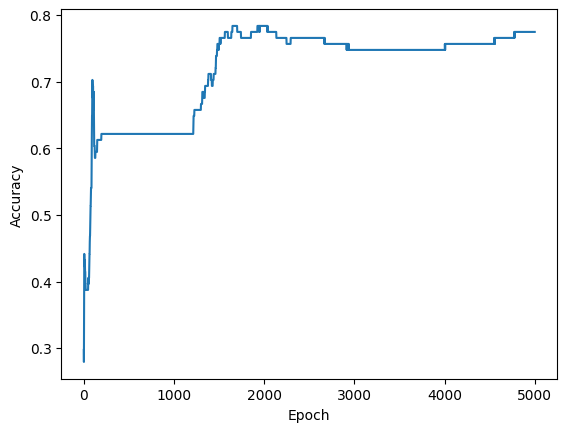

In [13]:
features = test_features.to(device)
a_norm = test_a_norm.to(device)
batch_idx = test_batch_idx.to(device)
labels = test_labels.to(device)
output = model.forward(features, a_norm, batch_idx)
output = torch.sigmoid(output)
predicted = torch.round(output)
acc = (predicted == labels).sum().item() / labels.shape[0]
print(acc)
# print(output)
# for p in model.parameters():
#     print(p.grad.sum())


import pandas as pd
df = pd.DataFrame.from_dict(results)
import seaborn as sns
# sns.lineplot(data=df, x='Epoch', y='Loss')
sns.lineplot(data=df, x='Epoch', y='Accuracy')